In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from resizeimage import resizeimage
from PIL import Image
from keras.models import model_from_json
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.optimizers import Adam
from keras import backend as K
from keras.layers.advanced_activations import LeakyReLU, ELU
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import math


Using TensorFlow backend.


In [ ]:
def shift_image_pixel(image, steer, trans_range):
    # Shape of image
    rows, cols = image.shape[:2]
#     print('height is {}'.format(rows))
#     print('width is {}'.format(cols))
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_angle = steer + tr_x/trans_range*2*.2
#     print('pixel shift is {}'.format(tr_x))
#     print('angle shift is {}'.format(tr_x/trans_range*2*.2))
    #tr_y = 40*np.random.uniform()-40/2
    tr_y = 0
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols, rows))
    
    return image_tr, steer_angle

In [ ]:
# test shift_image_pixel
img = cv2.imread('test.jpg')
processed_img, shifted_angle = shift_image_pixel(img, 10, 100)
#show before image
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

#show after image
plt.axis("off")
plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
plt.show() 

In [ ]:
def add_random_brightness(image_data):
    # Convert to HSV from RGB
    hsv = cv2.cvtColor(image_data, cv2.COLOR_RGB2HSV)
    # Generate random number to apply to brightness channel
    rand = random.uniform(0.25,1.0)
    hsv[:,:,2] = rand*hsv[:,:,2]
    # Convert back to RGB colorspace
    processed_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return processed_img 

In [ ]:
# test add_random_brightness
img = cv2.imread('test.jpg')
processed_img = add_random_brightness(img)
#show before image
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

#show after image
plt.axis("off")
plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
plt.show() 

In [63]:
# parameters for the model
EPOCHS = 8 
img_width, img_height = 320, 160
n_channels = 3  # color image has 3 channels
RESIZE_IMAGE_W = 200
RESIZE_IMAGE_H = 66
batch_size = 128
user_data = False
CROP_PIXEL_FROM_TOP = 60
CROP_PIXEL_FROM_BOTTOM = 25

In [ ]:
# Crop the sky and car hood
def crop_image(image_data):
    shape = image_data.shape
    cropped_img = image_data[CROP_PIXEL_FROM_TOP:shape[0]-CROP_PIXEL_FROM_BOTTOM,:]
    return cropped_img

In [ ]:
# test crop_image
img = cv2.imread('test.jpg')
processed_img = crop_image(img)
#show before image
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

#show after image
plt.axis("off")
plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
plt.show() 
print('cropped image width is {}'.format(processed_img.shape[1]))
print('cropped image height is {}'.format(processed_img.shape[0]))

In [ ]:
if (user_data == True):
  csv_file_path = 'driving_log.csv'
else:
  csv_file_path = 'data//driving_log.csv'

In [ ]:
def flip_image(img, angle):
    flipped_img = cv2.flip(img,1)
    angle = -angle
    return flipped_img, angle

In [ ]:
# test flip_image
img = cv2.imread('test.jpg')
steering_angle = 15.
processed_img, angle = flip_image(img, steering_angle)
#show before image
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

#show after image
plt.axis("off")
plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
plt.show() 
print('flipped image width is {}'.format(processed_img.shape[1]))
print('flipped image height is {}'.format(processed_img.shape[0]))
print('angle before flipping is {}'.format(steering_angle))
print('angle after flipping is {}'.format(angle))

In [ ]:
def transform_image_in_y_axis(image):
    mu, sigma = 0.9, 0.1 # mean and standard deviation
    ratio = np.random.normal(mu, sigma)
    img_h,img_w,ch = image.shape
    input_pts = np.float32([[0,0],[img_w,0],[0,img_h]])
    output_h_top = img_h * (1.0 - ratio)/2
    output_h_bottom = img_h - output_h_top
    output_pts = np.float32([[0,output_h_top],[img_w,output_h_top],[0,output_h_bottom]])
    M = cv2.getAffineTransform(input_pts,output_pts)
    processed_img = cv2.warpAffine(image,M,(img_w,img_h))
    return processed_img

In [ ]:
# test transform_image_in_y_axis
img = cv2.imread('test.jpg')
steering_angle = 15.
processed_img = transform_image_in_y_axis(img)
#show before image
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

#show after image
plt.axis("off")
plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
plt.show() 
print('squeezed image width is {}'.format(processed_img.shape[1]))
print('squeezed image height is {}'.format(processed_img.shape[0]))

In [30]:
def add_random_shadow(image):
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    #random_bright = .25+.7*np.random.uniform()
    if np.random.randint(2)==1:
        random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image

In [ ]:
def add_random_shadow_v2(image):
    original = image.copy()
    h, w = image.shape[0], image.shape[1]
    [x1, x2] = np.random.choice(w, 2, replace=False)
    k = h / (x2 - x1)
    b = - k * x1
    for i in range(h):
        c = int((i - b) / k)
        image[i, :c, :] = (image[i, :c, :] * .5).astype(np.int32)
    return image, original

In [131]:
def add_random_shadow_with_polygon(image):
    overlay = image.copy()
    output = image.copy()
    black = (0, 0, 0)
    top_x1, top_x2, bottom_x1, bottom_x2 = 0, img_width, 0, img_width
    random_choice = np.random.randint(2)
    if (random_choice == 1):
        # shadow fills to the left edge
        top_x2 = np.random.randint(1, img_width)
        bottom_x2 = np.random.randint(1, img_width)
    else:
        # shadow fills to the right edge
        top_x1 = np.random.randint(1, img_width)
        bottom_x1 = np.random.randint(1, img_width)
    
    points = np.array([[top_x1, 0], [top_x2, 0], [bottom_x2, img_height], [bottom_x1, img_height]], np.int32)
    cv2.fillConvexPoly(overlay, points, black)
    alpha = 0.6
    cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)
    return output

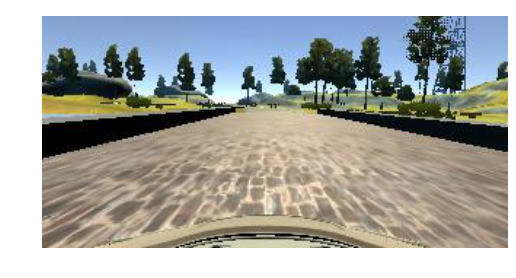

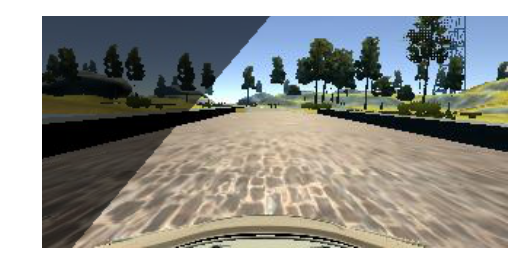

In [143]:
# add_random_shadow
img = cv2.imread('test.jpg')
steering_angle = 15.
processed_img = add_random_shadow_with_polygon(img)
#show before image
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

#show after image
plt.axis("off")
plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
plt.show() 

In [ ]:
# this is the output labels for each frame
driving_log = pd.read_csv(csv_file_path)
steering_angles = driving_log['steering']
steering_angles = np.array(steering_angles)
n_train_data = steering_angles.shape[0]
print('number of train data is {}'.format(n_train_data))

if user_data == True:
  image_file_names = driving_log['center']
else:
  image_file_names = 'data//' + driving_log['center']

In [ ]:
# define the model with Keras
nb_filters = 32
nb_filters_2 = 64
nb_filters_3 = 128
kernel_size_w = 3
kernel_size_h = 3
dropout = 0.5
learning_rate = 0.0001
# define the split if valiation set is used
split = 0.1
n_val_data = int(n_train_data*split)
n_split_train_data = n_train_data - n_val_data

print('shape of steering_angles is {}'.format(steering_angles.shape))
input_shape = (RESIZE_IMAGE_H, RESIZE_IMAGE_W, n_channels)
model = Sequential()
model.add(Lambda(lambda x: x/255 - 0.5, input_shape = input_shape))
model.add(Convolution2D(nb_filters, kernel_size_w, kernel_size_h, border_mode='valid', subsample =(2,2)))
model.add(Dropout(dropout))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters_2, kernel_size_w, kernel_size_h, border_mode='valid', subsample =(2,2)))
model.add(Dropout(dropout))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters_3, kernel_size_w, kernel_size_h, border_mode='valid', subsample =(2,2)))
model.add(Dropout(dropout))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(512))
# model.add(Dropout(dropout))
model.add(ELU())   # add an advanced activation
model.add(Dense(64))
model.add(ELU())   # add an advanced activation
model.add(Dense(16))
model.add(ELU())   # add an advanced activation
model.add(Dense(1))
adam = Adam(lr = learning_rate)
model.compile(loss='mse', optimizer=adam, metrics=['accuracy'])

In [ ]:
def select_image_and_process(index):
    # pick a random image from one of the cameras: (left, center, right)
    # and add/subtract angles if necessary
    random_choice = np.random.randint(3)
    if (random_choice == 0):
        img_file = 'data/' + driving_log['left'].str.strip()
        shift_ang = .20
    if (random_choice == 1):
        img_file = 'data/' + driving_log['center'].str.strip()
        shift_ang = 0.
    if (random_choice == 2):
        img_file = 'data/' + driving_log['right'].str.strip()
        shift_ang = -.20  
#     print('random choice is {}'.format(random_choice))
    
#     print('file index is {}'.format(index))
#     print('file name is {}'.format(img_file[index]))    
    # create Numpy arrays of input data
    # and labels, using each row in the csv file
    x = cv2.imread(img_file[index])
    x = cv2.cvtColor(x,cv2.COLOR_BGR2RGB)
    y = np.array(steering_angles[index])
#     print('steering angle is {}'.format(y))  
    x = add_random_brightness(x)
    x, y = shift_image_pixel(x, y, 100)
    x = crop_image(x)
    # car is turnning left or right: for steering angles greather than 0.1
    # stretch or squeeze the image to simulate view point change in the y-axis
    if (abs(y) > 0.11):
        x = transform_image_in_y_axis(x)    
    x = cv2.resize(x, (RESIZE_IMAGE_W, RESIZE_IMAGE_H), interpolation=cv2.INTER_AREA)
    y = np.add(y, shift_ang)
    
    # randomly fiip the image
    should_flip = np.random.randint(2)
    if should_flip==1:
        x, y = flip_image(x, y)

    return x, y # x: processed image, y: processed angle

In [ ]:
def data_generator_with_batch(path, batch_size):
    x_batch = np.zeros((batch_size, RESIZE_IMAGE_H, RESIZE_IMAGE_W, n_channels), dtype = np.float32)
    y_batch = np.zeros((batch_size,), dtype = np.float32)
    pr_threshold = 1
    epoch_i = 1
    counter = 0
    while 1:
        for i in range(batch_size):
            if (counter < (n_split_train_data*3)):
                counter += 1
            else:
                # 1 epoch
                counter = 0
                epoch_i += 1
                print('\n pr_threshold is {}'.format(1 / epoch_i))

            #start out as 1, i.e. chance of dropping small angles is high in early rounds
            pr_threshold = 1 / epoch_i 
            keep_pr = 0
            while keep_pr == 0:
                random_pick = np.random.randint(n_train_data)
                x_batch[i], y_batch[i] = select_image_and_process(random_pick)
                # if the angle is too small, we may need to drop this training data so that
                # it has less influence on the learning
                if abs(y_batch[i]) < 0.1:
                    pr_val = np.random.uniform()
                    if pr_val > pr_threshold:
                        keep_pr = 1
                else:
                    keep_pr = 1
        yield x_batch, y_batch

In [ ]:
train_generator = data_generator_with_batch(csv_file_path, batch_size)
# validation_generator = data_generator_with_batch(csv_file_path, batch_size, data_type='validation')
#print(next(train_generator))
# print(next(validation_generator))
model.fit_generator(train_generator, samples_per_epoch=(3*n_split_train_data), nb_epoch=EPOCHS, initial_epoch=0)
# model.fit_generator(train_generator, samples_per_epoch=(n_split_train_data*3), 
#     nb_epoch=EPOCHS, validation_data=validation_generator, nb_val_samples=n_val_data)

In [ ]:
# save the model and trained weights
model_name = 'model.json'
model_json = model.to_json()
with open(model_name, "w") as json_file:
    json_file.write(model_json)
    print("model saved to disk as {}".format(model_name))
model_weight_name = 'model.h5'
model.save_weights(model_weight_name)  # save the weights after training or during training
print("model weight saved to disk as {}".format(model_weight_name))